# Censored Data Models

[This example notebook on Bayesian survival
analysis](http://docs.pymc.io/notebooks/survival_analysis.html) touches on the
point of censored data. _Censoring_ is a form of missing-data problem, in which
observations greater than a certain threshold are clipped down to that
threshold, or observations less than a certain threshold are clipped up to that
threshold, or both. These are called right, left and interval censoring,
respectively. In this example notebook we consider interval censoring.

Censored data arises in many modelling problems. Two common examples are:

1. _Survival analysis:_ when studying the effect of a certain medical treatment
   on survival times, it is impossible to prolong the study until all subjects
   have died. At the end of the study, the only data collected for many patients
   is that they were still alive for a time period $T$ after the treatment was
   administered: in reality, their true survival times are greater than $T$.

2. _Sensor saturation:_ a sensor might have a limited range and the upper and
   lower limits would simply be the highest and lowest values a sensor can
   report. For instance, many mercury thermometers only report a very narrow
   range of temperatures.

This example notebook presents two different ways of dealing with censored data
in PyMC3:

1. An imputed censored model, which represents censored data as parameters and
   makes up plausible values for all censored values. As a result of this
   imputation, this model is capable of generating plausible sets of made-up
   values that would have been censored. Each censored element introduces a
   random variable.

2. An unimputed censored model, where the censored data are integrated out and
   accounted for only through the log-likelihood. This method deals more
   adequately with large amounts of censored data and converges more quickly.

To establish a baseline we compare to an uncensored model of the uncensored
data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

sns.set_style('whitegrid')

In [2]:
# Produce normally distributed samples
np.random.seed(1618)
size = 500
mu = 13.
sigma = 5.
samples = np.random.normal(mu, sigma, size)

# Set censoring limits
high = 16.
low = -1.

# Censor samples
censored = samples[(samples > low) & (samples < high)]

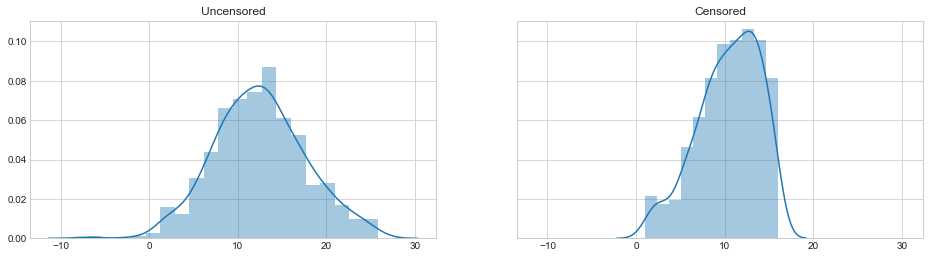

In [3]:
# Visualize uncensored and censored data
_, axarr = plt.subplots(ncols=2, figsize=[16, 4], sharex=True, sharey=True)
for i, data in enumerate([samples, censored]):
    sns.distplot(data, ax=axarr[i])
axarr[0].set_title('Uncensored')
axarr[1].set_title('Censored')
plt.show()

## Baseline - Uncensored Model of Uncensored Data

In [4]:
# Uncensored model

with pm.Model() as uncensored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=samples)

## Model 1 - Imputed Censored Model of Censored Data

In this model, we impute the censored values from the same distribution as the uncensored data. Sampling from the posterior generates possible uncensored data sets.

This model makes use of [PyMC3's bounded variables](https://docs.pymc.io/api/bounds.html).

In [5]:
# Imputed censored model

n_right_censored = len(samples[samples >= high])
n_left_censored = len(samples[samples <= low])
n_observed = len(samples) - n_right_censored - n_left_censored

with pm.Model() as imputed_censored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    
    right_censored = pm.Bound(pm.Normal, lower=high)(
        'right_censored', mu=mu, sd=sigma, shape=n_right_censored
    )
    left_censored = pm.Bound(pm.Normal, upper=low)(
        'left_censored', mu=mu, sd=sigma, shape=n_left_censored
    )
    
    observed = pm.Normal(
        'observed',
        mu=mu,
        sd=sigma,
        observed=censored,
        shape=n_observed
    )

## Model 2 - Unimputed Censored Model of Censored Data

In this model, we do not impute censored data, but instead integrate them out through the likelihood.

The implementations of the likelihoods are non-trivial. See the [Stan manual](https://github.com/stan-dev/stan/releases/download/v2.14.0/stan-reference-2.14.0.pdf) (section 11.3 on censored data) and the [original PyMC3 issue on GitHub](https://github.com/pymc-devs/pymc3/issues/1833) for more information.

Note that we use Theano's `erfcx` operation for numerical stability. See [this Theano docstring](https://github.com/Theano/Theano/blob/7495a50a94d4c961598523b38c8630ce13d1c9dd/theano/scalar/basic_scipy.py#L90) for more details. Essentially, computing `log(erfcx(x)) - x**2` is sometimes more numerically stable than computing `log(erfc(x))` directly.

This model makes use of [PyMC3's `Potential`](https://docs.pymc.io/api/model.html#pymc3.model.Potential).

In [6]:
# Helper functions for unimputed censored model

def normal_lcdf(mu, sigma, x):
    '''
    Log cdf of a Normal distribution.
    If x is more than one standard deviation below the mean,
    switch to erfcx implementation for numerical stability.
    '''
    z = (x - mu) / sigma
    return tt.switch(
        tt.lt(z, -1.0),
        tt.log(tt.erfcx(-z / tt.sqrt(2.)) / 2.) - tt.sqr(z) / 2.,
        tt.log1p(-tt.erfc(z / tt.sqrt(2.)) / 2.)
    )


def normal_lccdf(mu, sigma, x):
    '''
    Log complementary cdf of a Normal distribution.
    If x is more than one standard deviation above the mean,
    switch to erfcx implementation for numerical stability.
    '''
    z = (x - mu) / sigma
    return tt.switch(
        tt.gt(z, 1.0),
        tt.log(tt.erfcx(z / tt.sqrt(2.)) / 2.) - tt.sqr(z) / 2.,
        tt.log1p(-tt.erfc(-z / tt.sqrt(2.)) / 2.)
    )


def left_censored_likelihood(mu, sigma, n_left_censored, lower_bound):
    ''' Likelihood of left-censored data. '''
    return n_left_censored * normal_lcdf(mu, sigma, lower_bound)


def right_censored_likelihood(mu, sigma, n_right_censored, upper_bound):
    ''' Likelihood of right-censored data. '''
    return n_right_censored * normal_lccdf(mu, sigma, upper_bound)

In [7]:
# Unimputed censored model

with pm.Model() as unimputed_censored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    
    observed = pm.Normal(
        'observed',
        mu=mu,
        sd=sigma,
        observed=censored,
    )
    
    left_censored = pm.Potential(
        'left_censored',
        left_censored_likelihood(mu, sigma, n_left_censored, low)
    )
    right_censored = pm.Potential(
        'right_censored',
        right_censored_likelihood(mu, sigma, n_right_censored, high)
    )

## Sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2591.59draws/s]


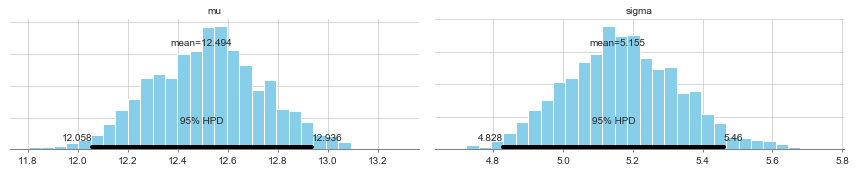

In [8]:
# Uncensored model
with uncensored_model:
    trace = pm.sample(draws=1000, tune=1000)
    pm.plot_posterior(trace)
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [left_censored, right_censored, sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 560.55draws/s]


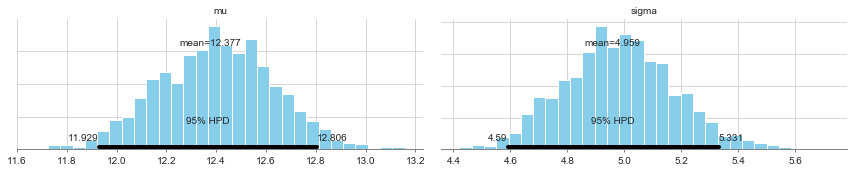

In [9]:
# Imputed censored model
with imputed_censored_model:
    trace = pm.sample(draws=1000, tune=1000)
    pm.plot_posterior(trace, varnames=['mu', 'sigma'])
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2023.94draws/s]


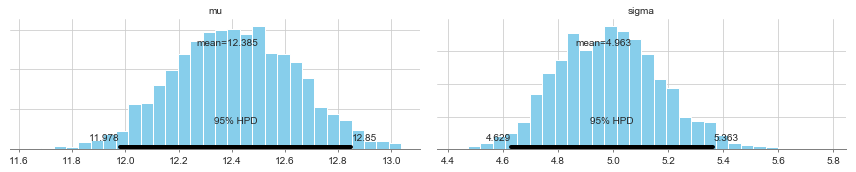

In [10]:
# Unimputed censored model
with unimputed_censored_model:
    trace = pm.sample(draws=1000, tune=1000)
    pm.plot_posterior(trace, varnames=['mu', 'sigma'])
    plt.show()

## Discussion

As we can see, both censored models appear to capture the mean and variance of the underlying distribution as well as the uncensored model! In addition, the imputed censored model is capable of generating data sets of censored values (sample from the posteriors of `left_censored` and `right_censored` to generate them), while the unimputed censored model scales much better with more censored data, and converges faster.